<a href="https://colab.research.google.com/github/joshmurr/machine-learnings/blob/master/cci-dsai/DCGAN_Keras_Cutsom_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN - Custom Dataset
## Deep Convolutional GAN

This is much the same as the previous notebook we looked at (still using the [official Keras DCGAN implementation](https://keras.io/examples/generative/dcgan_overriding_train_step/)) but I have some extra code at the start to allow you to make your own dataset from a YouTube video!

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile
import cv2
import math
import random

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


We have to install [YouTube-DL](https://youtube-dl.org/) via pip in the cell below.

In [1]:
!pip install --upgrade --quiet youtube_dl

     |████████████████████████████████| 1.9MB 8.8MB/s 


All you need to do is to run the cell below. It just contains helper functions to download a YouTube video and to extract frames from the video to make the dataset. Feel free to poke around if you're interested.

In [8]:
# Some helper functions we will use to make the dataset

from __future__ import unicode_literals
import youtube_dl


class MyLogger(object):
    def debug(self, msg):
        pass

    def warning(self, msg):
        pass

    def error(self, msg):
        print(msg)


def my_hook(d):
    if d['status'] == 'finished':
        print('Done downloading.')

def download_youtube_video(_url):
  ydl_opts = {
      'format': '(mp4)[height>=256][height<=400]',
      'outtmpl': '%(id)s.%(ext)s',
      'logger': MyLogger(),
      'progress_hooks': [my_hook],
  }
  with youtube_dl.YoutubeDL(ydl_opts) as ydl:
      result = ydl.extract_info(_url, download=True)

  if 'entries' in result:
    video = result['entries'][0]
  else:
    video = result

  return video

def analyse_video(_videoPath):
  vidcap = cv2.VideoCapture(_videoPath)
  success, frame = vidcap.read()

  frameCount = 0
  darkFrames = []
  validFrames = []

  while success:
    grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    average = grey.mean(axis=0).mean(axis=0)

    if average < 2:
      darkFrames.append(frameCount)
    else:
      validFrames.append(frameCount)
    
    success, frame = vidcap.read()
    frameCount += 1
  
  print(f'Found {len(darkFrames)} dark frames.')
  return validFrames, darkFrames

def extract_frames(_videoPath, _outputPath, _num, _size):
  SIZE = _size[0]
  MAX = _num
  count = 0
  id = 0
  validFrames, darkFrames = analyse_video(_videoPath)
  doubles = []
  frames = []

  if MAX > len(validFrames):
    numDoubles = MAX - len(validFrames)
    doubles = np.random.choice(validFrames, size=numDoubles, replace=False)
    frames = validFrames
  else:
    frames = np.random.choice(validFrames, size=MAX, replace=False)

  vidcap = cv2.VideoCapture(_videoPath)
  success, frame = vidcap.read()

  frameHeight = frame.shape[0]
  frameWidth = frame.shape[1]

  scaleFactor = SIZE / frameHeight
  newWidth = int(frameWidth * scaleFactor)
  padding = int((newWidth - SIZE) / 2)

  while success:
    if count in frames:
      frame = cv2.resize(frame, (newWidth, SIZE), interpolation=cv2.INTER_AREA)
      crops = []

      if count in doubles:
        crops = [frame[0:SIZE, 0:SIZE],
                frame[0:SIZE, padding*2:SIZE+padding*2]]
      else:
        crops = [frame[0:SIZE, padding:SIZE+padding]]

      for crop in crops:
        try:
          cv2.imwrite(os.path.join(_outputPath, f'{id:04}.jpg'), crop)
          id += 1
        except:
          print("Error saving frame.")
          pass
    
    count += 1
    success, frame = vidcap.read()

  print(f"Saved {id} images from video '{videoInfo['title']}'")

  return id

# Choose a YouTube Video

Find a video on YouTube which is about 4-10 minutes long. The video can be anything but ideally it will be generally consistent throughout. So timelapse video are perfect, [like this video of clouds forming](https://www.youtube.com/watch?v=NJfI_GaEyJw), or [this video of life underwater](https://www.youtube.com/watch?v=J2BKd5e15Jc) has nice consistent colours and forms. However it is entirely up to you, maybe it would be interesting to get a random video of Lady Gaga dresses.. who knows!

Paste the YouTube video URL in the cell below, __replacing the url that is between the single quotes__.

If the URL is long like this:

```
https://www.youtube.com/watch?v=NJfI_GaEyJw&ab_channel=wizard327
                                           ^
                       We don't need the stuff after this & symbol.
```

just trim the end off after (and including) the '__&__' symbol.

In [5]:
url = 'https://www.youtube.com/watch?v=J2BKd5e15Jc' # Coral Reef
videoInfo = download_youtube_video(url)
videoFile = "{0}.{1}".format(videoInfo['webpage_url'].split('=')[-1], videoInfo['ext'])

Done downloading.


If your video has an intro and an outro we can trim that off! Change the `startTime` and `endTime` values below. The values need to be in seconds, so if the good bit of the video start at 38 seconds then enter `38` for `startTime`. If the end credits start at 9:14, then an easy way to find the seconds is `(9*60)+14`.

__If you don't need to trim the video down then just don't run the cell below.__

In [6]:
# Optional trimming of the video to remove intro / end credits.
# Skip this if your video does not need trimming.

from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

def trim_video(_video, _start, _end):
  trimmedVideo = f"trimmed.{videoInfo['ext']}"
  ffmpeg_extract_subclip(videoFile, _start, _end, targetname=trimmedVideo)
  return trimmedVideo


startTime = 38
endTime = (9*60)+14
videoFile = trim_video(videoFile, startTime, endTime)


[MoviePy] Running:
>>> /usr/bin/ffmpeg -y -i J2BKd5e15Jc.mp4 -ss 38.00 -t 516.00 -vcodec copy -acodec copy trimmed.mp4
... command successful.


Next we make some directories and extract 3000 images from the the video.

In [45]:
DATASET_DIR = 'dataset'
IMAGES_DIR = f"{DATASET_DIR}/images"
OUTPUT_DIR = 'output'
IMAGE_SIZE =(64, 64)
try:
  os.makedirs(DATASET_DIR)
  os.makedirs(IMAGES_DIR)
  os.makedirs(OUTPUT_DIR)
except:
  pass
NUM_IMAGES = extract_frames(f"/content/{videoFile}", IMAGES_DIR, 3000, IMAGE_SIZE)

As with before we then turn it into a _Tensorflow dataset_.

In [24]:
dataset = keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR, label_mode=None, image_size=IMAGE_SIZE, batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 3000 files belonging to 1 classes.


All things going well, if you run the cell below you should see frames from the video you chose being taken from the dataset we created.

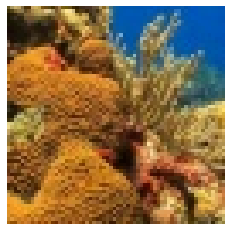

In [28]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

# Defining the Model

This is the same as the previous example.

In [34]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)            

In [35]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 64, 64, 512)       20

In [36]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [47]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=1, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(os.path.join(OUTPUT_DIR, "generated_img_%03d_%d.png" % (epoch, i)))


# Train the GAN

Now our dataset is much much smaller than [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) and so this will train a lot quicker.

Unfortunately Keras likes to output a lot of it's own information during training which makes it difficult to display images using `imshow` or something similar. But as with before images from the generator are saved to a directory called `output` which you can find in the file explorer on the left.

Epoch 1/60
94/94 [==============================] - 28s 285ms/step - d_loss: 0.6400 - g_loss: 1.2332
Epoch 2/60
94/94 [==============================] - 26s 271ms/step - d_loss: 0.5953 - g_loss: 1.2073
Epoch 3/60
94/94 [==============================] - 25s 268ms/step - d_loss: 0.6342 - g_loss: 0.8853
Epoch 4/60
94/94 [==============================] - 26s 274ms/step - d_loss: 0.6151 - g_loss: 1.2905
Epoch 5/60
94/94 [==============================] - 26s 273ms/step - d_loss: 0.7016 - g_loss: 1.3243
Epoch 6/60
94/94 [==============================] - 25s 270ms/step - d_loss: 0.6161 - g_loss: 1.2665
Epoch 7/60
94/94 [==============================] - 26s 271ms/step - d_loss: 0.6431 - g_loss: 1.1417
Epoch 8/60
94/94 [==============================] - 26s 272ms/step - d_loss: 0.6399 - g_loss: 1.1628
Epoch 9/60
94/94 [==============================] - 26s 271ms/step - d_loss: 0.6681 - g_loss: 1.4785
Epoch 10/60
94/94 [==============================] - 25s 270ms/step - d_loss: 0.6093 - g_lo

KeyboardInterrupt: ignored

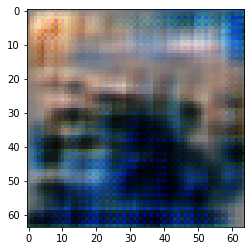

In [49]:
epochs = 60

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=1, latent_dim=latent_dim)]
)